# Installing Seurat package

In [1]:
##Run only in colab:
#install.packages('Seurat')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘plyr’, ‘zoo’, ‘hexbin’, ‘data.table’, ‘rappdirs’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘goftest’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘rsvd’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘shiny’, ‘spatstat’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [2]:
library(Seurat)

library(ggplot2)
library(dplyr)

# Download data

Dataset: GSE137804

Sample: GSM4654672

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4654672



We will need either:
 * 3 files: cell barcode -- barcodes.tsv.gz, gene annotation -- features.tsv.gz, count matrix (gene x cell) -- matrix.mtx.gz
 * h5 file with the same data

All of these files are provided as the outut of the standard ```cellranger count``` pipeline

In [5]:
dir.create('GSM4654672/', showWarnings=F)

#Saving all three tables to GSM4654672/

# Annotation of barcodes=cells
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/GSM4654672/barcodes.tsv.gz', 'GSM4654672/barcodes.tsv.gz')

# Annotation of features=genes
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/GSM4654672/features.tsv.gz', 'GSM4654672/features.tsv.gz')

# (Sparse) count matrix (gene x cells)
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/GSM4654672/matrix.mtx.gz', 'GSM4654672/matrix.mtx.gz')

# Run Seurat analysis -- keeping the cell cycle

## Load data and create Seurat object

In [6]:
path = 'GSM4654672/'
project_name = 'T200'

data = Read10X(path)
SR = CreateSeuratObject(counts = data, project = project_name, min.cells = 3, min.features = 200)
SR

An object of class Seurat 
22595 features across 14355 samples within 1 assay 
Active assay: RNA (22595 features, 0 variable features)

## Estumate % of mitochondrial RNA, filter cells

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


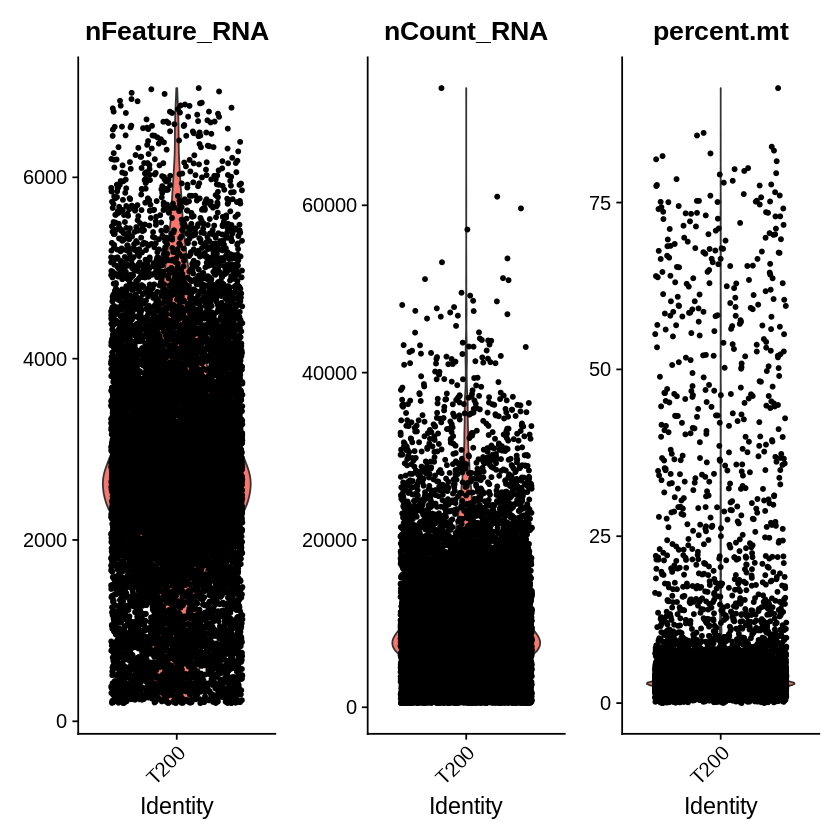

An object of class Seurat 
22595 features across 13922 samples within 1 assay 
Active assay: RNA (22595 features, 0 variable features)

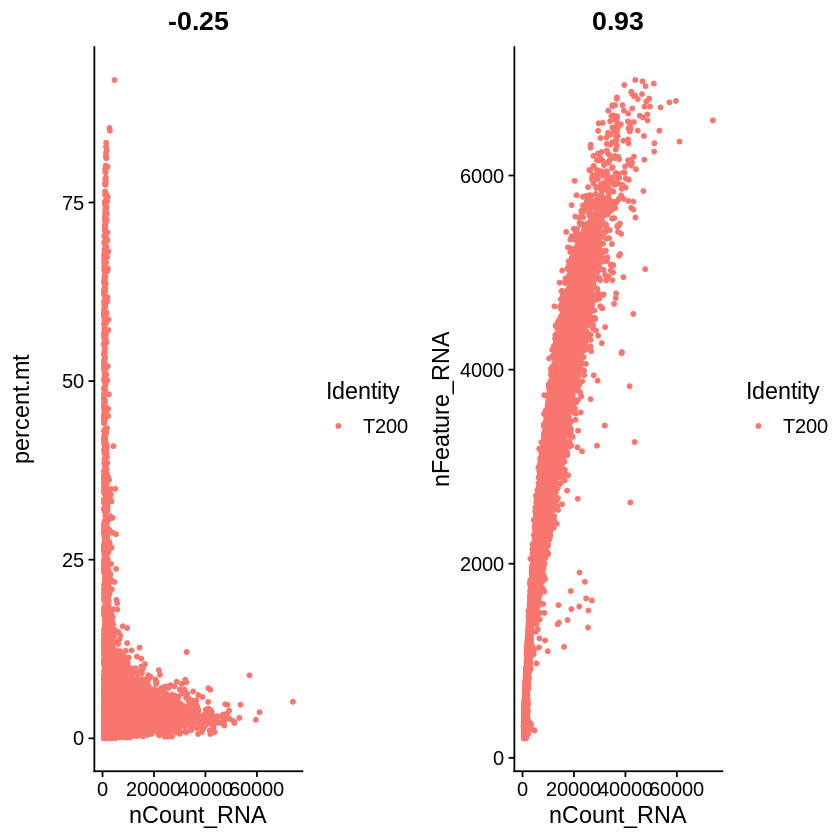

In [8]:
# % of RNA from mitochondrial genes
SR[["percent.mt"]] <- PercentageFeatureSet(SR, pattern = "^MT-")

# Plot %mt and total RNA count
VlnPlot(SR, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(SR, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(SR, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot(CombinePlots(plots = list(plot1, plot2)))

# Filter cells
SR <- subset(SR, subset = nFeature_RNA > 200 & nFeature_RNA < 7000 & percent.mt < 25)

SR

## Normalize data

In [9]:
SR <- NormalizeData(SR)

## Find variable genes

When using repel, set xnudge and ynudge to 0 for optimal results



[1] "FABP4"  "TAGLN"  "ACTA2"  "CCL4L2" "APOE"   "APOC1"  "GNLY"   "IGKC"  
 [9] "GNG11"  "C1QB"   "CCL3L1" "IGHG1"  "CCL4"   "IGHG4"  "C1QC"   "C1QA"  
[17] "MGP"    "CCL3"   "HMOX1"  "CXCL10"

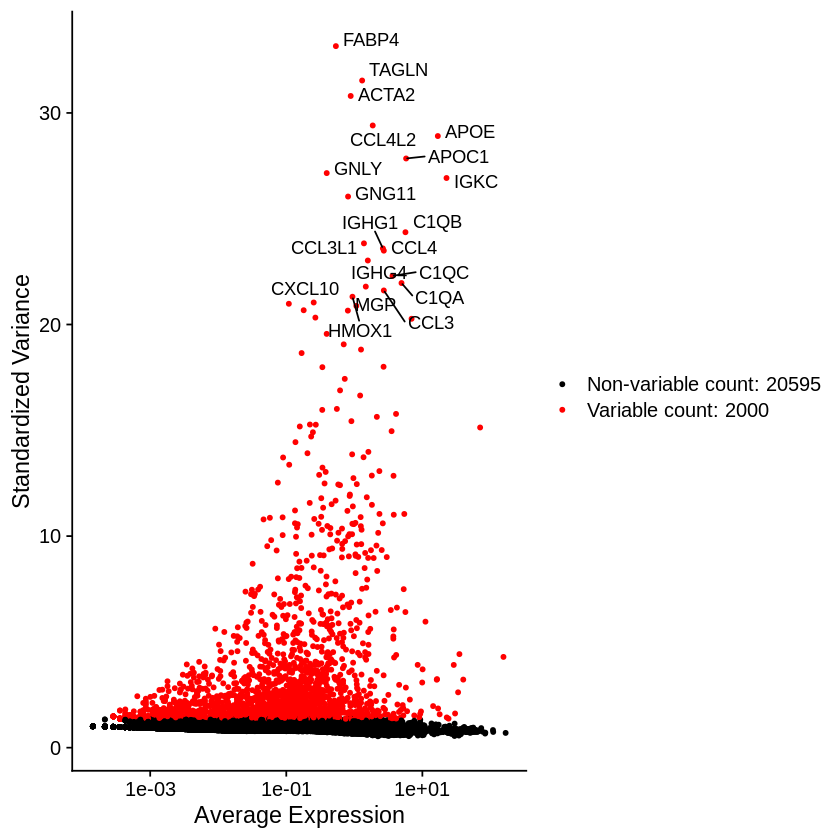

In [10]:
SR <- FindVariableFeatures(SR, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(SR), 20)
plot1 <- VariableFeaturePlot(SR)
plot(LabelPoints(plot = plot1, points = top10, repel = TRUE))

top10

## Scale data
Regress out:
* % mitochondrial RNA
* total RNA
* cell cycle

In [11]:
SR <- ScaleData(SR, vars.to.regress = c("nFeature_RNA", "nCount_RNA", "percent.mt"))

Regressing out nFeature_RNA, nCount_RNA, percent.mt

Centering and scaling data matrix



## Dimension reduction: PCA
ElbowPlot: How many principal components to take?


PC_ 1 
Positive:  DDX1, TUBA1A, NBAS, TUBB, STMN2, RPL23, TUBB2A, HIST1H4C, NNAT, VEGFD 
	   HDAC9, MAOA, FAM49A, SOX11, NPY, HSP90AA1, MYCN, NCL, HMGB1, TESC 
	   H2AFZ, CELF4, MEG3, TMEM97, GAP43, HSPE1, PEG10, DUT, AKAP12, HMGB3 
Negative:  S100A11, HLA-B, HLA-A, FCGRT, HLA-E, HLA-C, CYBA, CD74, GRN, SRGN 
	   BST2, TYMP, HLA-DRB1, VAMP5, IFITM3, CTSZ, CTSC, HLA-DRB5, SAT1, CTSS 
	   HLA-DRA, ZFP36, IFI44L, NPC2, CD14, GADD45B, ZFP36L1, LAPTM5, CD68, TYROBP 
PC_ 2 
Positive:  TYROBP, MS4A6A, MS4A7, CD14, AIF1, FCER1G, C1QA, C1QC, C1QB, FGL2 
	   CD68, CD163, CPVL, CCL3, CFD, APOC1, LST1, FCGR3A, CTSS, CSF1R 
	   CCL3L1, LYZ, C5AR1, CYBB, MS4A4A, IL1B, MPEG1, CXCL8, CXCL2, SIGLEC1 
Negative:  IGFBP7, SPARC, COL4A1, COL4A2, CAV1, FN1, ID3, MGP, SPARCL1, CAVIN3 
	   LAMA4, UACA, COL18A1, CAVIN1, BGN, IGFBP4, MYL9, CALD1, PRSS23, ADGRF5 
	   GSN, GNG11, MCAM, COX7A1, CRIP2, TGFB1I1, ESAM, CAV2, SERPINH1, MYLK 
PC_ 3 
Positive:  PLAC9, NDUFA4L2, COL1A1, COL1A2, TAGLN, NOTCH3, COL3A1, ADI

PC_ 1 
Positive:  DDX1, TUBA1A, NBAS, TUBB, STMN2 
Negative:  S100A11, HLA-B, HLA-A, FCGRT, HLA-E 
PC_ 2 
Positive:  TYROBP, MS4A6A, MS4A7, CD14, AIF1 
Negative:  IGFBP7, SPARC, COL4A1, COL4A2, CAV1 
PC_ 3 
Positive:  PLAC9, NDUFA4L2, COL1A1, COL1A2, TAGLN 
Negative:  CLEC14A, PLVAP, SOX18, CD34, VWF 
PC_ 4 
Positive:  MEG3, GAP43, STMN2, SCG2, RBP1 
Negative:  TOP2A, CENPF, NUSAP1, MKI67, BIRC5 
PC_ 5 
Positive:  TUBB, UBE2C, BIRC5, PIMREG, CCNB1 
Negative:  NKG7, GZMA, CCL5, CST7, CD3D 


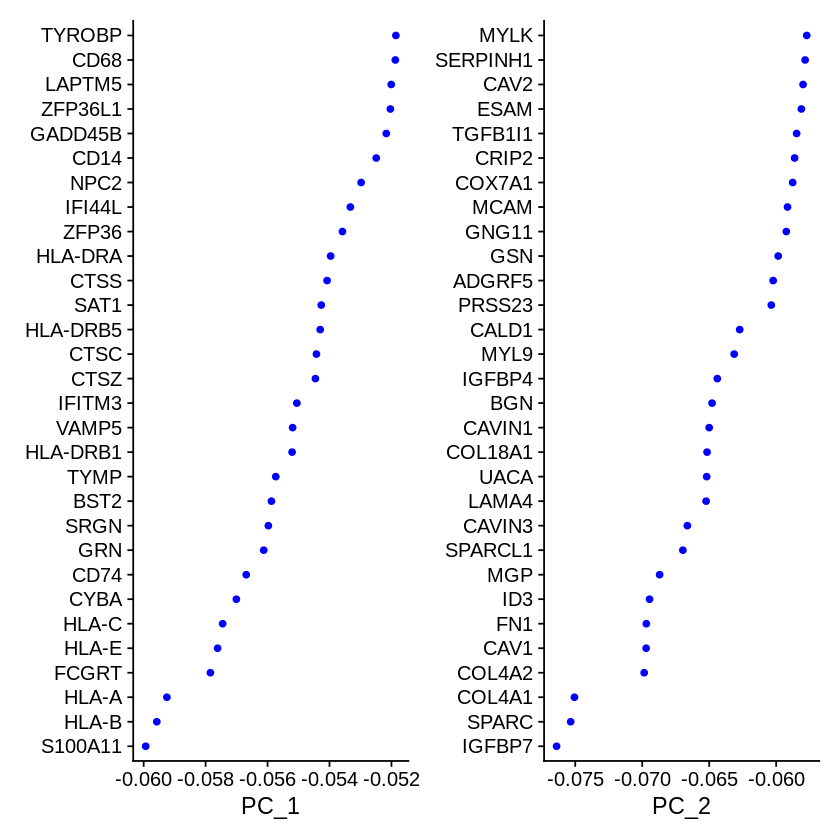

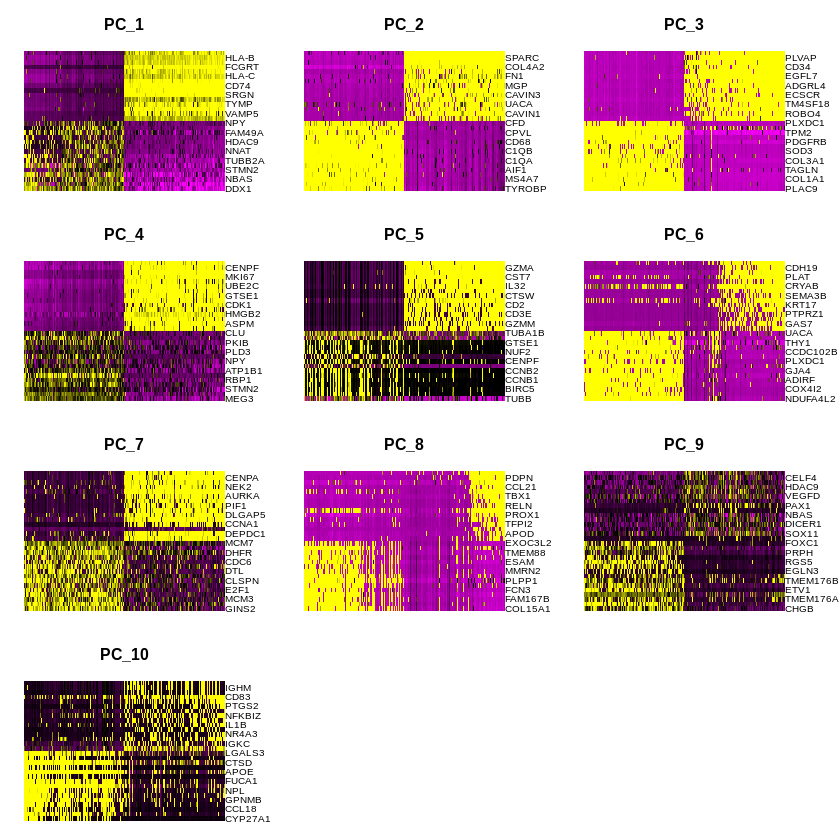

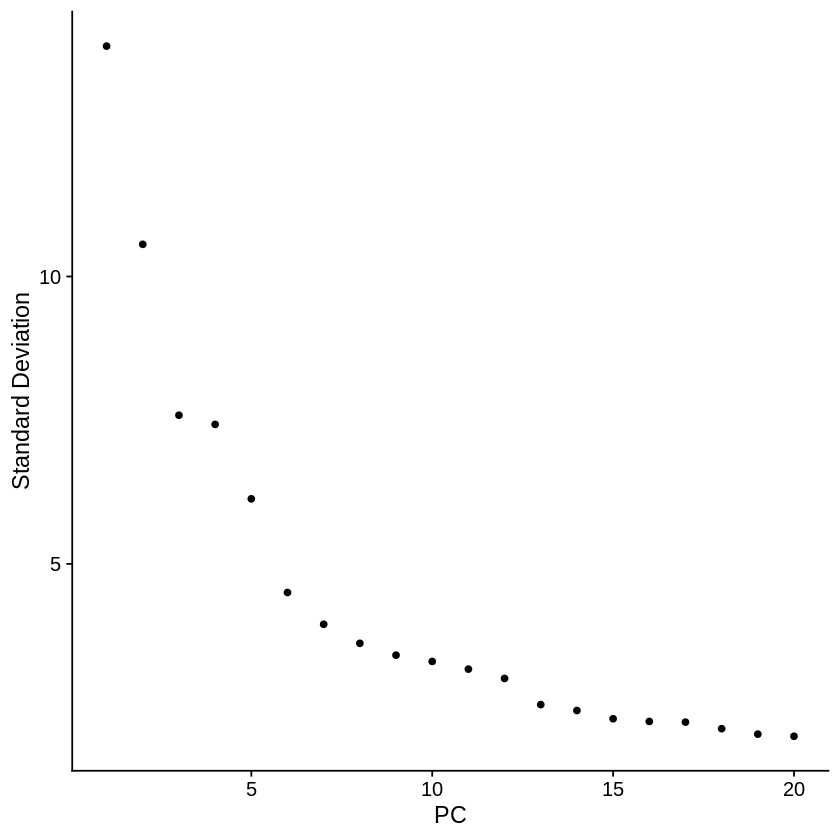

In [12]:
SR <- RunPCA(SR, features = VariableFeatures(object = SR))
print(SR[["pca"]], dims = 1:5, nfeatures = 5)
plot(VizDimLoadings(SR, dims = 1:2, reduction = "pca"))

DimHeatmap(SR, dims = 1:10, cells = 500, balanced = TRUE)

SR <- JackStraw(SR, num.replicate = 100)
SR <- ScoreJackStraw(SR, dims = 1:20)
plot(ElbowPlot(SR))

## Clustering and UMAP embedding
* Find nearest neighbors for every cell. This results in a graph (some of cells are connected to each other)
* Find clusters
* Run UMAP - based on nearest neighbors graph

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13922
Number of edges: 435152

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 14
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:40:39 UMAP embedding parameters a = 0.9922 b = 1.112

02:40:39 Read 13922 rows and found 15 numeric columns

02:40:39 Using Annoy for neighbor search, n_neighbors = 30

02:40:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:40:41 Writing NN index file to temp file /tmp/RtmprsfFgR/file397b1764e3

02:40:41 Searching Annoy index using 1 thread, search_k = 3000

02:40:49 Annoy recall = 100%

02:40:49 Commencing smooth kNN distance calibration using 1 thread

02:40:50 Initializing from

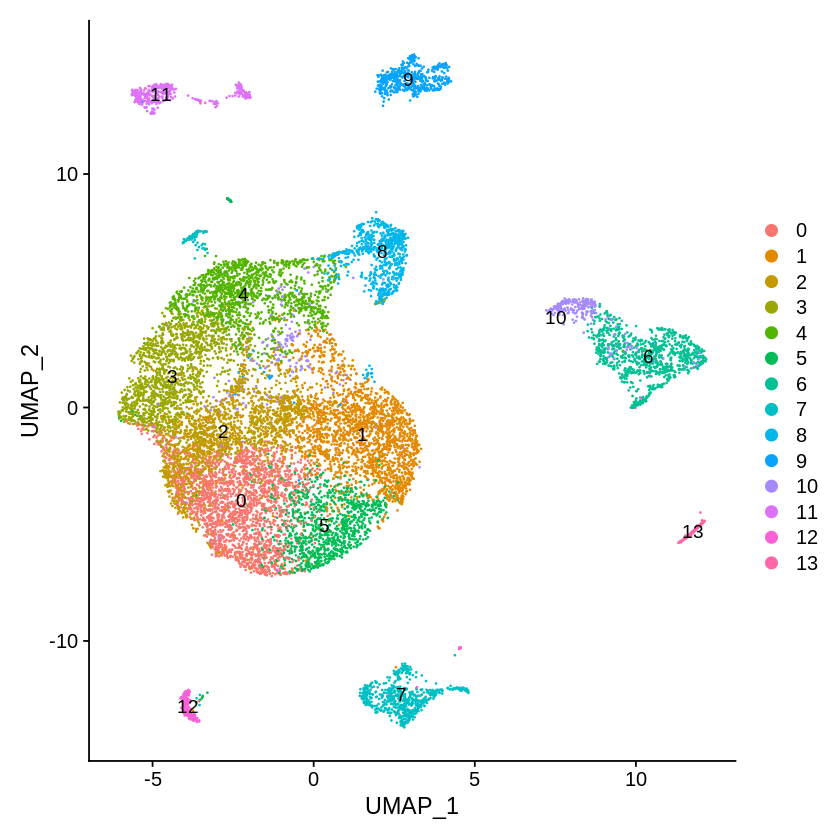

In [13]:
SR <- FindNeighbors(SR, dims = 1:10)
SR <- FindClusters(SR, resolution = 0.5)

SR <- RunUMAP(SR, dims = 1:15)

DimPlot(SR, reduction = "umap", label=T)


## Find marker genes for each cluster and visualize them

In [34]:
# Find markers for each cluster
# only.pos -- only positive markers (i.e. higher in that cluster)
# min.pct -- expressed in at lest min.pct of cells
# logfc.threshold -- minimal log fold change
# test='roc' -- Area under curve test
SR.markers.AUC <- FindAllMarkers(SR, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test='roc')

library(dplyr)
top5 <- SR.markers.AUC %>% group_by(cluster) %>% top_n(n = 5, wt = myAUC)

DotPlot(SR, features = unique(top5$gene), cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

top5

Calculating cluster 0



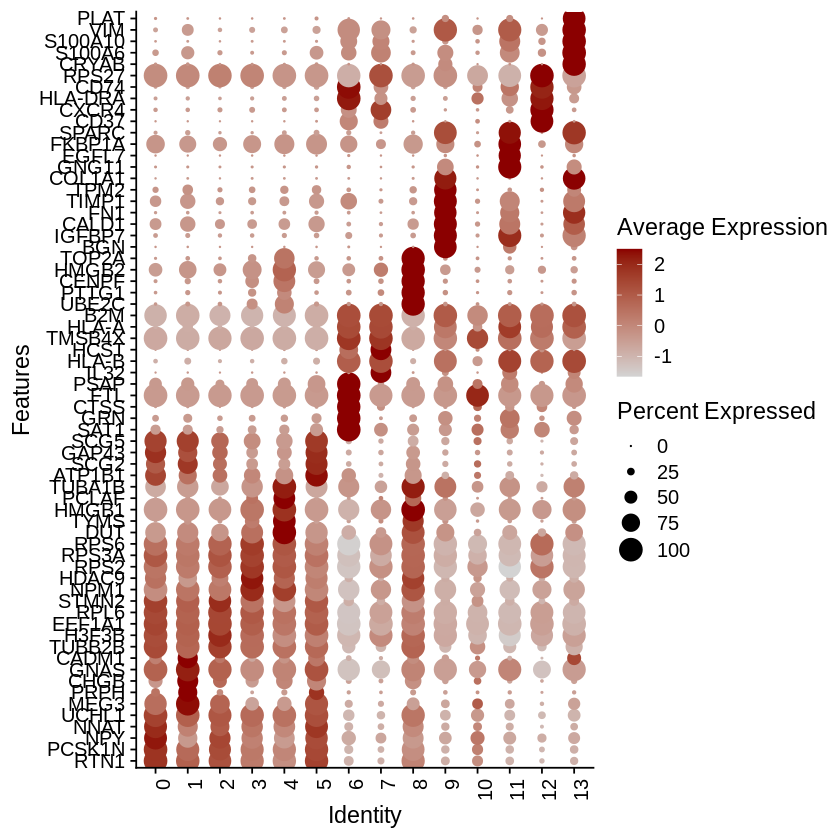

In [17]:
DotPlot(SR, features = unique(top5$gene), cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

#save to PDF
ggsave('dotplot.pdf', width=8, height=13)

## Visualize some of the discovered markers

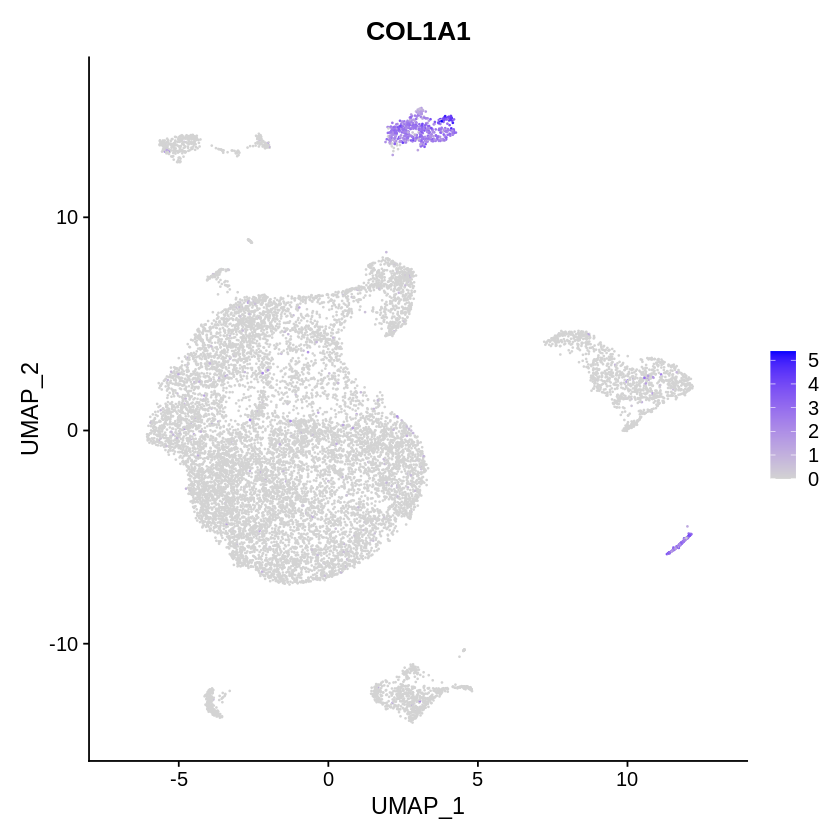

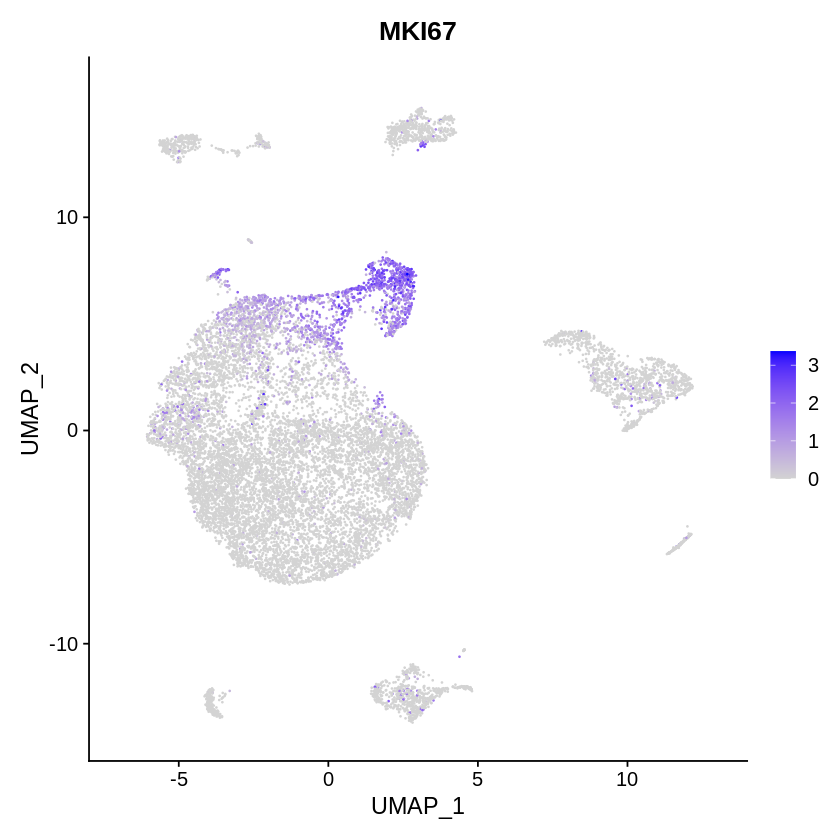

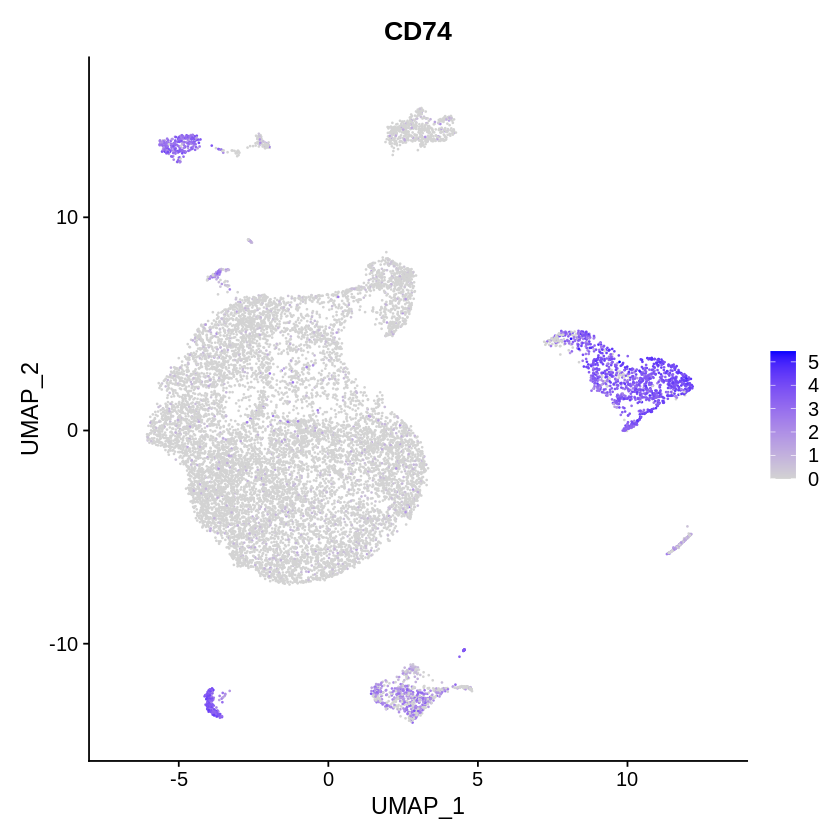

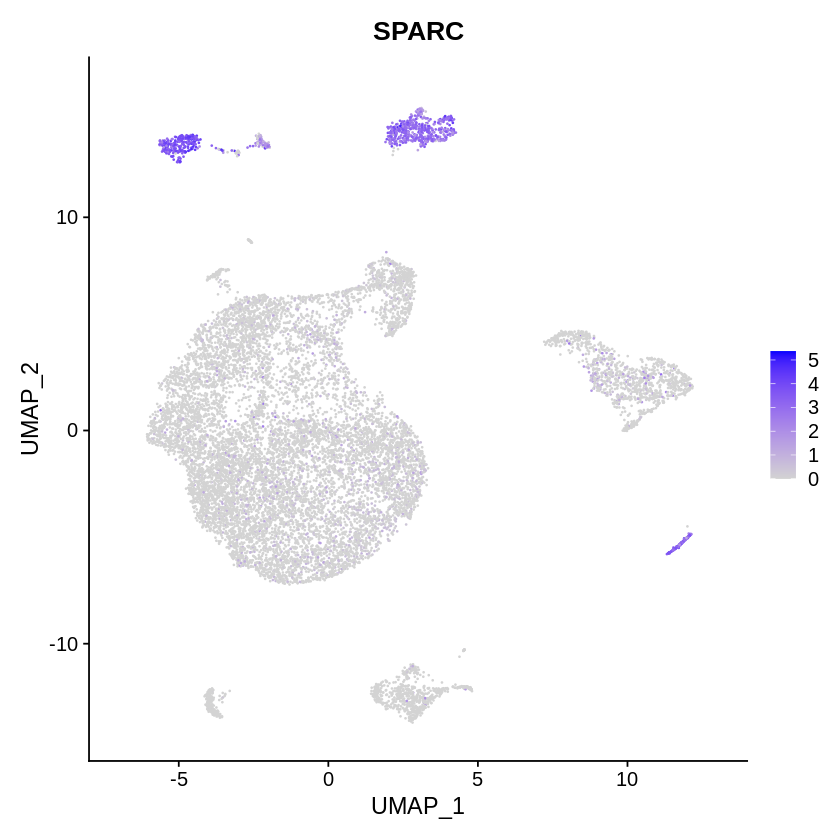

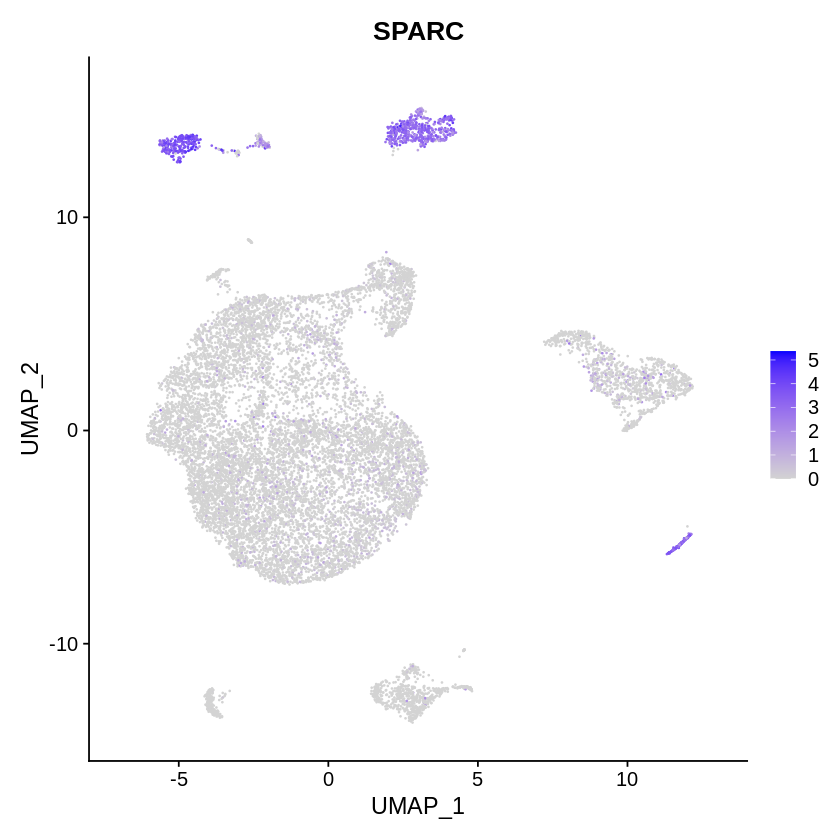

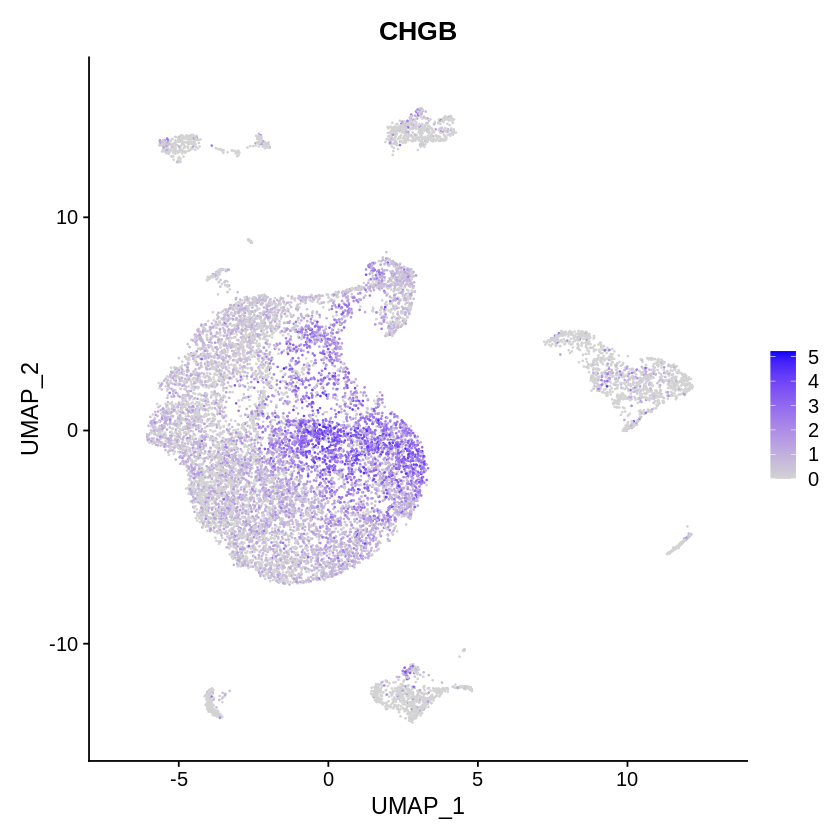

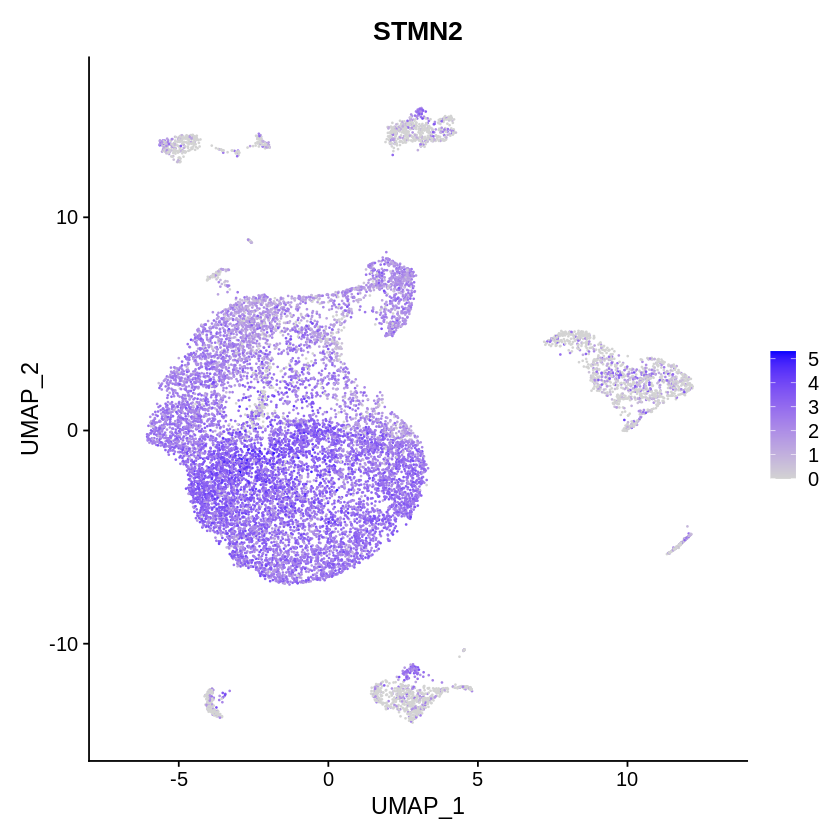

In [18]:
FeaturePlot(SR, 'COL1A1') # mesenchyme-like
FeaturePlot(SR, 'MKI67') # cycling cells
FeaturePlot(SR, 'CD74')
FeaturePlot(SR, 'SPARC')
FeaturePlot(SR, 'SPARC')
FeaturePlot(SR, 'CHGB')
FeaturePlot(SR, 'STMN2')


# Run seurat analysis -- regressing out the cell cycle

* Find cell cycle scores, 2 values that characterize how likely a cell is in S plase (S.Score), and in G2M phase (G2M.Score)
* (optional) PCA on these scores
* Regress out these two values (S.Score, G2M.Score)



In [20]:
# cc.genes - from Seurat package
# list of two vectors with gene names
names(cc.genes)
head(cc.genes$s.genes)
head(cc.genes$g2m.genes)

[1] "s.genes"   "g2m.genes"

[1] "MCM5" "PCNA" "TYMS" "FEN1" "MCM2" "MCM4"

[1] "HMGB2"  "CDK1"   "NUSAP1" "UBE2C"  "BIRC5"  "TPX2"

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Picking joint bandwidth of 0.0776

Picking joint bandwidth of 0.119

Picking joint bandwidth of 0.0623

Picking joint bandwidth of 0.0703

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 34 features requested have not been scaled (running reduction without them): MCM5, MCM2, UNG, CDCA7, PRIM1, UHRF1, MLF1IP, RFC2, RPA2, WDR76, SLBP, CCNE2, UBR7, POLD3, MSH2, RAD51, EXO1, TIPIN, DSCC1, BLM, CASP8AP2, USP1, POLA1, CHAF1B, BRIP1, E2F8, FAM64A, HN1, CDC25C, RANGAP1, LBR, CTCF, G2E3, CBX5”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  MCM4, CDC6, DTL, HELLS, FEN1, MCM6, CDC45, CKAP5,

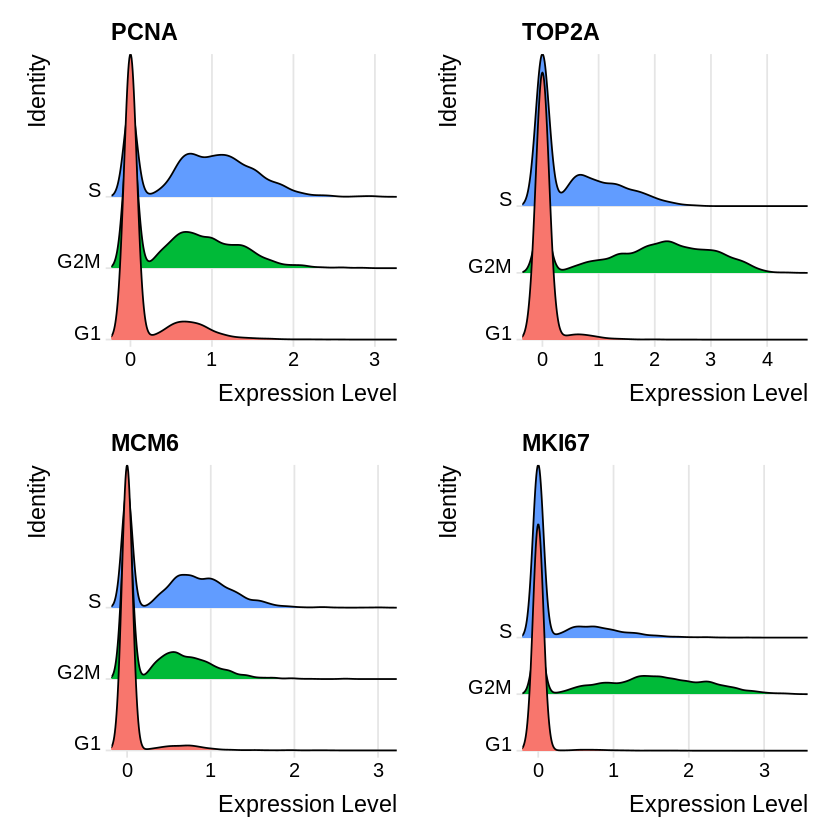

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  STMN2, DDX1, TUBA1A, NBAS, TUBB, RPL23, NNAT, TUBB2A, MAOA, MEG3 
Negative:  S100A11, HLA-B, HLA-A, FCGRT, CD74, SRGN, CYBA, HLA-E, HLA-C, TYMP 
PC_ 2 
Positive:  TYROBP, MS4A6A, MS4A7, CD14, AIF1, FCER1G, C1QA, C1QC, C1QB, CD68 
Negative:  IGFBP7, SPARC, COL4A1, COL4A2, ID3, CAV1, FN1, MGP, SPARCL1, CAVIN3 
PC_ 3 
Positive:  PLAC9, NDUFA4L2, COL1A1, COL1A2, TAGLN, NOTCH3, ADIRF, COL3A1, SOD3, HIGD1B 
Negative:  CLEC14A, PLVAP, SOX18, CD34, VWF, EGFL7, KDR, ADGRL4, CDH5, ECSCR 
PC_ 4 
Positive:  NKG7, GZMA, CCL5, CST7, CD3D, IL32, CD52, CD2, GZMH, CTSW 
Negative:  TUBB, TUBA1A, CST3, PLD3, FOS, NBAS, CTSB, RPL23, CTSL, FAM49A 
PC_ 5 
Positive:  COL8A1, CDH19, S100B, PLAT, MIA, CRYAB, NOV, SEMA3B, TNFRSF12A, KRT17 
Negative:  NDUFA4L2, HIGD1B, COX4I2, TINAGL1, ADIRF, SPARCL1, GJA4, PLAC9, PLXDC1, SEPT4 



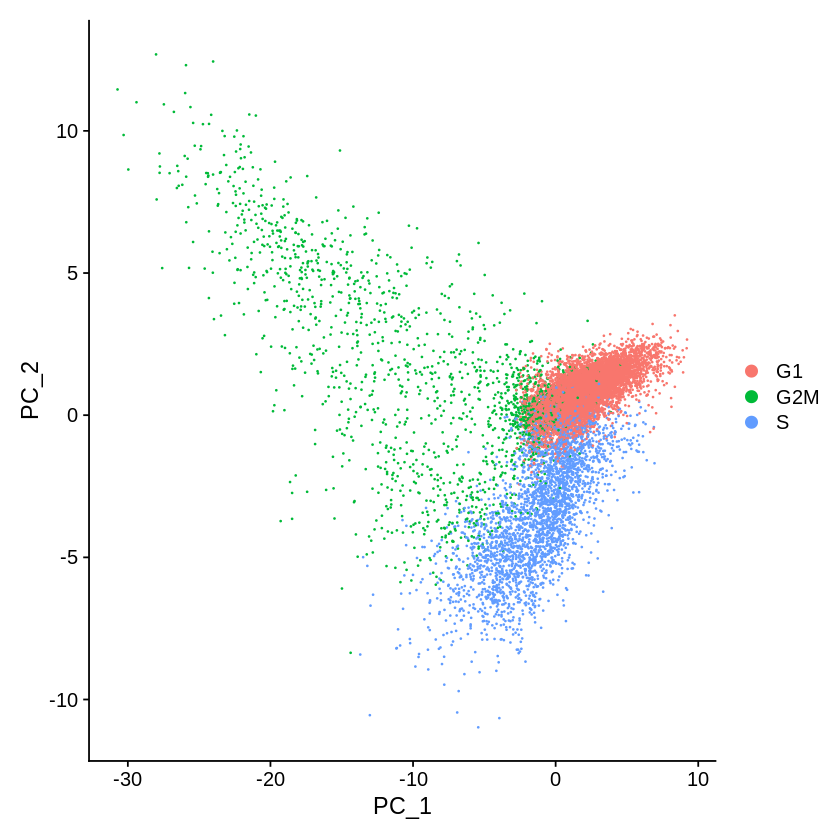

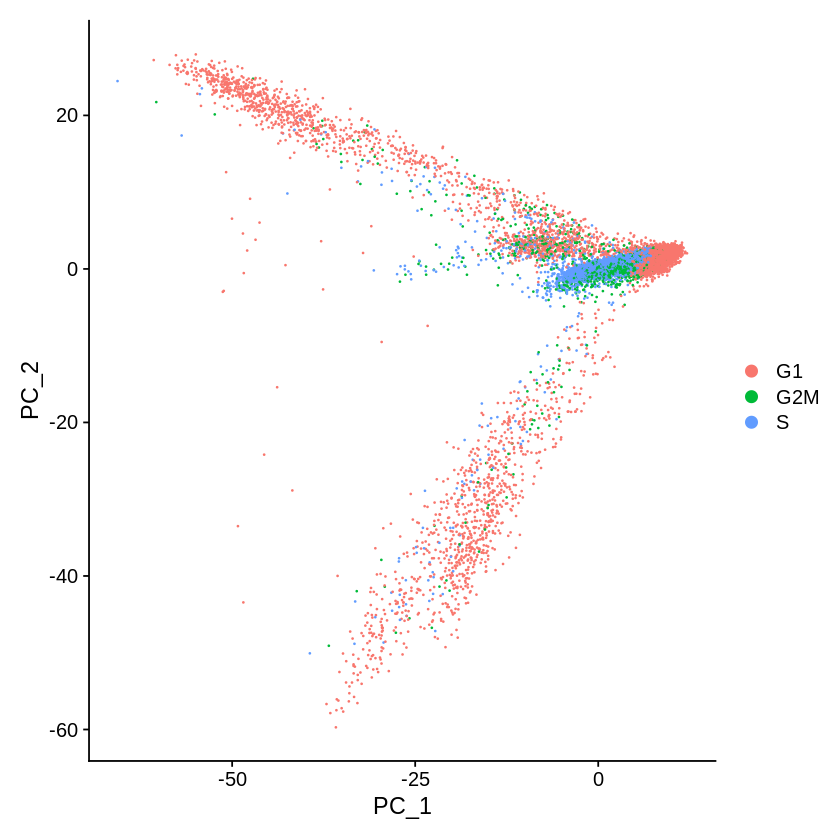

In [25]:
SR_noCC <- CellCycleScoring(SR, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)

# view cell cycle scores and phase assignments
plot(RidgePlot(SR_noCC, features = toupper(c("PCNA", "TOP2A", "MCM6", "MKI67")), ncol = 2))
#Run PCA based only on cell cycle genes
SR_noCC <- RunPCA(SR_noCC, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
#Plot PCA
DimPlot(SR_noCC, reduction='pca')

#Regress out S.Score and G2M.Score (see slides)
SR_noCC <- ScaleData(SR_noCC, vars.to.regress = c("S.Score", "G2M.Score"))
#Run PCA based on everything that is orthogonal to S.Score and G2M.Score
SR_noCC <- RunPCA(SR_noCC, features = VariableFeatures(SR_noCC), nfeatures.print = 10)
#Plot PCA
DimPlot(SR_noCC, reduction='pca')


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13922
Number of edges: 453942

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 17
Elapsed time: 2 seconds


03:28:21 UMAP embedding parameters a = 0.9922 b = 1.112

03:28:21 Read 13922 rows and found 15 numeric columns

03:28:21 Using Annoy for neighbor search, n_neighbors = 30

03:28:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:28:23 Writing NN index file to temp file /tmp/RtmprsfFgR/file398ed6ad0

03:28:23 Searching Annoy index using 1 thread, search_k = 3000

03:28:31 Annoy recall = 100%

03:28:31 Commencing smooth kNN distance calibration using 1 thread

03:28:32 Initializing from normalized Laplacian + noise

03:28:33 Commencing optimization for 200 epochs, with 569122 positive edges

03:28:42 Optimization finished



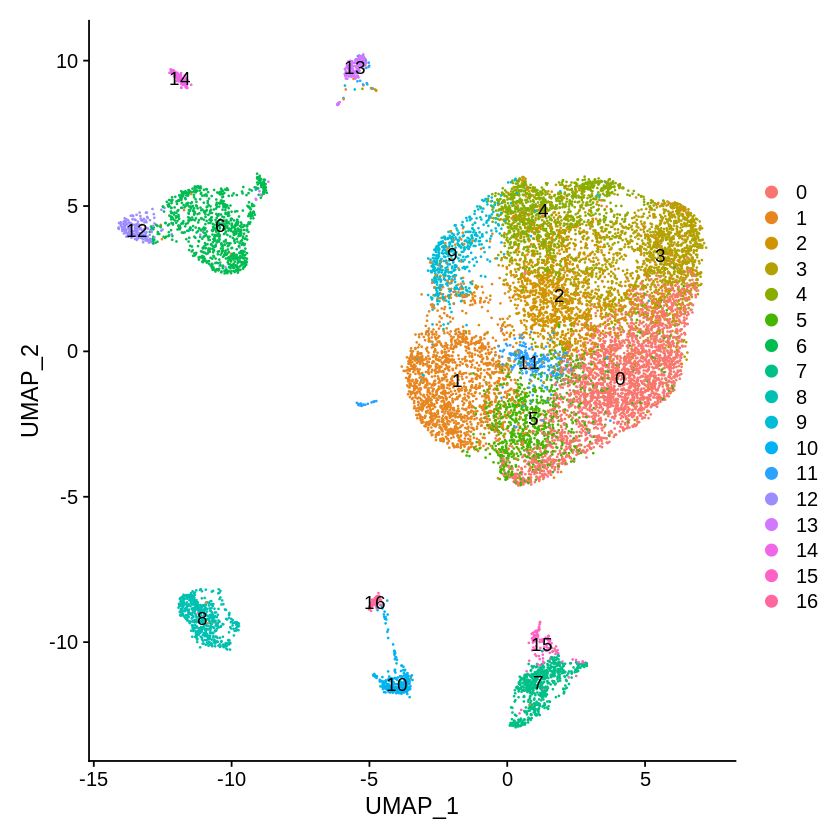

In [27]:
#same steps as without cell cycle regression (see above)

SR_noCC <- FindNeighbors(SR_noCC, dims = 1:10)
SR_noCC <- FindClusters(SR_noCC, resolution = 0.5)

SR_noCC <- RunUMAP(SR_noCC, dims = 1:15)
DimPlot(SR_noCC, reduction = "umap", label=T)

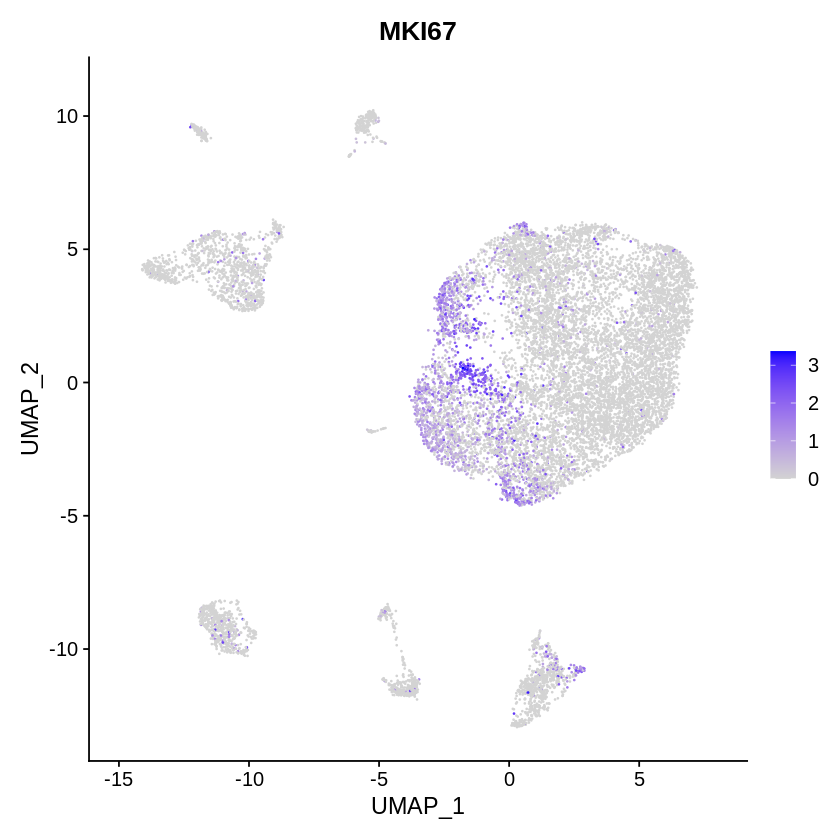

In [28]:
FeaturePlot(SR_noCC, 'MKI67') #Marker of cycling cells

In [29]:
SR_noCC@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters,S.Score,G2M.Score,Phase,old.ident
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
AAACCCAAGATACATG-1,T200,2636,1259,1.9347496,7,7,-0.078534707,-0.02119801,G1,7
AAACCCAAGATGGGCT-1,T200,8507,2361,5.0076408,0,0,-0.068026363,-0.13681162,G1,0
AAACCCAAGCGTTAGG-1,T200,31191,5375,3.8697060,4,4,-0.030595558,-0.11739129,G1,5
AAACCCAAGGTAGCAC-1,T200,4714,1815,3.6699194,0,0,-0.068317867,-0.14287426,G1,2
AAACCCAAGGTCACAG-1,T200,28766,5349,2.9653063,3,3,-0.064912351,-0.12888915,G1,5
AAACCCAAGTTCATCG-1,T200,5991,2352,2.6039059,8,8,-0.090343236,0.07232917,G2M,9
AAACCCACAACAAGAT-1,T200,2159,1081,0.5094951,7,7,-0.135272867,-0.01014565,G1,7
AAACCCACACCCAAGC-1,T200,10509,3127,6.6038634,1,1,0.349882087,0.13109006,S,4
AAACCCACATGACTCA-1,T200,19702,4831,3.4311237,9,9,0.426102984,0.56949364,G2M,4


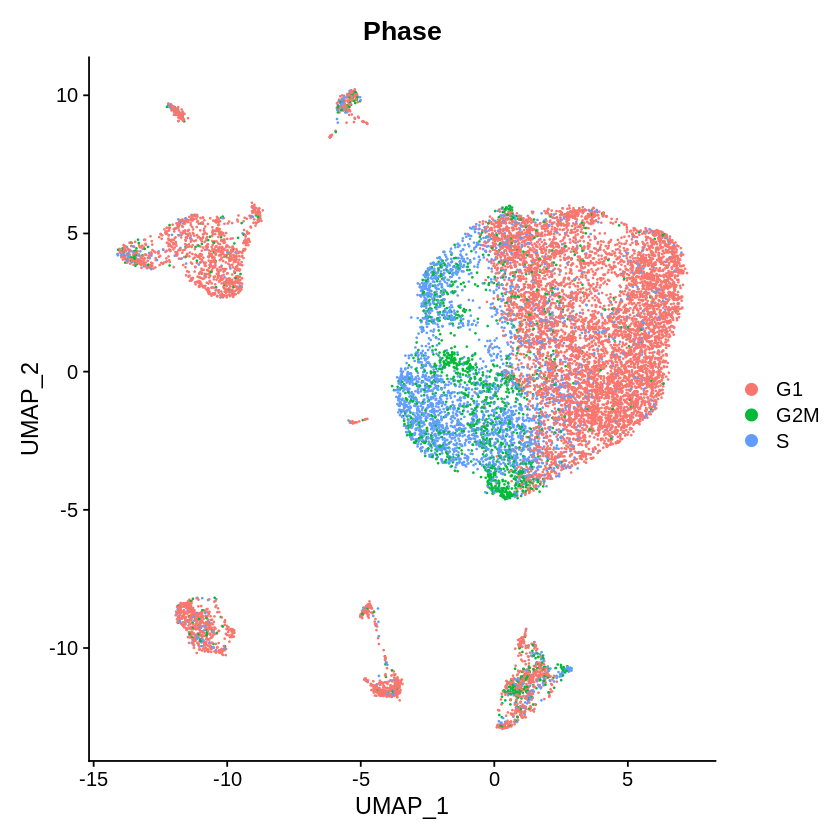

In [33]:
DimPlot(SR_noCC, group.by='Phase')